Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
Data was loaded by mounting the google drive.  
Link to download dataset - https://drive.google.com/file/d/1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs/view  
!unzip -q file[.zip] -d [exdir]  
-q suppress the printing of the file names being extracted  
-d [exdir] optional directory to which to extract files

### **Note -** Dataset was manually uploaded in drive and used for coding

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
root_path = '/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration'

In [4]:
root_path

'/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test')

In [6]:
data_dir_train

PosixPath('/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2255
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', 
    batch_size=32, image_size=(img_height,img_width), shuffle=True, seed=123, 
    validation_split=0.2, subset="training", interpolation='bilinear', follow_links=False
)

Found 2255 files belonging to 9 classes.
Using 1804 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', 
    batch_size=batch_size, image_size=(img_height,img_width), shuffle=True, seed=123, 
    validation_split=0.2, subset="validation", interpolation='bilinear', follow_links=False
)

Found 2255 files belonging to 9 classes.
Using 451 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

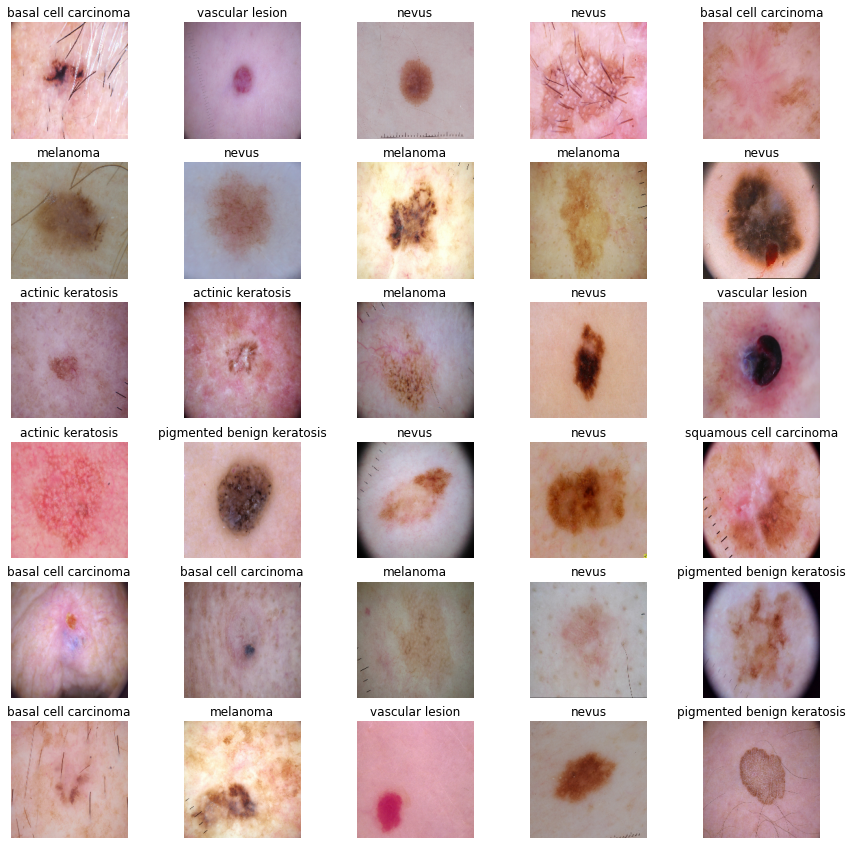

In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(30):
        ax = plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`  

Model 1 base model

In [15]:
### Your code goes here
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [16]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training    
Ans- I selected Adam optimizer because it achieves good results fast. This algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision. It combines the advantages of two other extensions of stochastic gradient descent : AdaGrad and RMSProp.  
CrossEntropyLoss is the appropriate loss function for a classification model that outputs raw scores for each class.  
Accuracy is chosen as the metric to determine the model performance.

In [17]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 899s 3s/step - loss: 2.0924 - accuracy: 0.2439 - val_loss: 1.7612 - val_accuracy: 0.3171
Epoch 2/20
57/57 [==============================] - 2s 41ms/step - loss: 1.6381 - accuracy: 0.4181 - val_loss: 1.6945 - val_accuracy: 0.3503
Epoch 3/20
57/57 [==============================] - 2s 41ms/step - loss: 1.4791 - accuracy: 0.4865 - val_loss: 1.5154 - val_accuracy: 0.4523
Epoch 4/20
57/57 [==============================] - 2s 41ms/step - loss: 1.3997 - accuracy: 0.4993 - val_loss: 1.4254 - val_accuracy: 0.5299
Epoch 5/20
57/57 [==============================] - 2s 41ms/step - loss: 1.2968 - accuracy: 0.5529 - val_loss: 1.3232 - val_accuracy: 0.5477
Epoch 6/20
57/57 [==============================] - 2s 41ms/step - loss: 1.1699 - accuracy: 0.5983 - val_loss: 1.3689 - val_accuracy: 0.5632
Epoch 7/20
57/57 [==============================] - 2s 41ms/step - loss: 1.0774 - accuracy: 0.6259 - val_loss: 1.3145 - val_accuracy: 0.5477
Epoch 8/20
57

### Visualizing training results

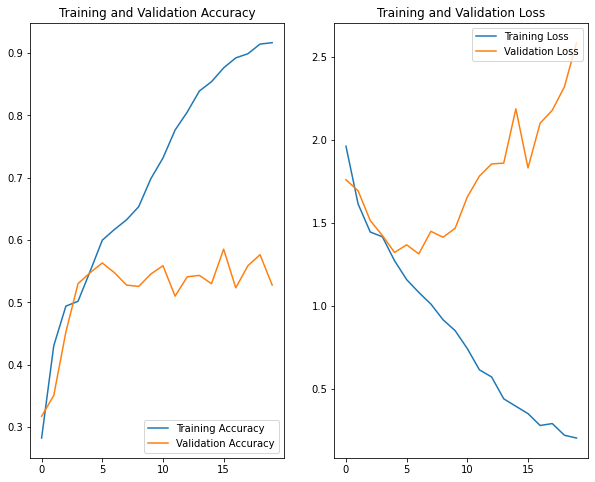

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit  

### Insights:
We can observe from the plots that training accuracy and validation accuracy are off by large margin and the model has achieved only around 52% accuracy on the validation set.
It's a clear sign of OverFitting  
### Overfitting
In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 50% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable from 83% to 52% — a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.  

We'll use data augmentation to fight overfitting in training process. It will help to expose the model to more aspects of the data and generalize better.
We'll be using the layers from tf.keras.layers.experimental.preprocessing.  

In [21]:
# Todo, after you have analysed the model fit history for presence of overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

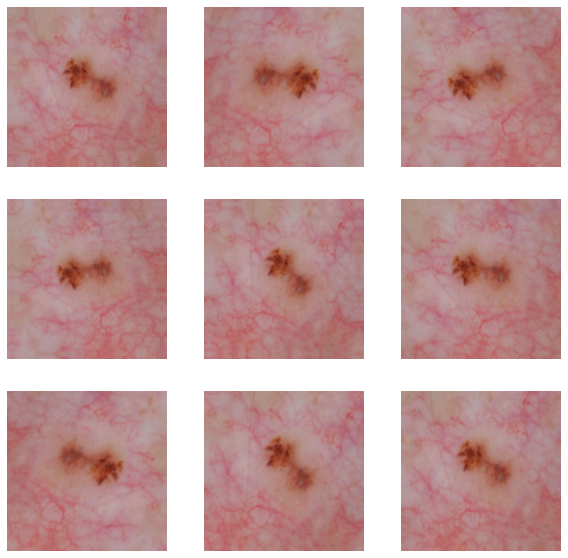

In [22]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo: Create the model, compile and train the model  
Model 2 with Data Augmentation


In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [25]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

### Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs
## your training code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 4s 51ms/step - loss: 2.3097 - accuracy: 0.1757 - val_loss: 1.9599 - val_accuracy: 0.3082
Epoch 2/20
57/57 [==============================] - 3s 46ms/step - loss: 1.9387 - accuracy: 0.2943 - val_loss: 1.7218 - val_accuracy: 0.4257
Epoch 3/20
57/57 [==============================] - 3s 46ms/step - loss: 1.7286 - accuracy: 0.3783 - val_loss: 1.5041 - val_accuracy: 0.4967
Epoch 4/20
57/57 [==============================] - 3s 46ms/step - loss: 1.5814 - accuracy: 0.4388 - val_loss: 1.4303 - val_accuracy: 0.5188
Epoch 5/20
57/57 [==============================] - 3s 46ms/step - loss: 1.4121 - accuracy: 0.5059 - val_loss: 1.4292 - val_accuracy: 0.5166
Epoch 6/20
57/57 [==============================] - 3s 46ms/step - loss: 1.3735 - accuracy: 0.5242 - val_loss: 1.4264 - val_accuracy: 0.5078
Epoch 7/20
57/57 [==============================] - 3s 46ms/step - loss: 1.3667 - accuracy: 0.4983 - val_loss: 1.6832 - val_accuracy: 0.3991
Epoch 8/20
57

### Visualizing the results

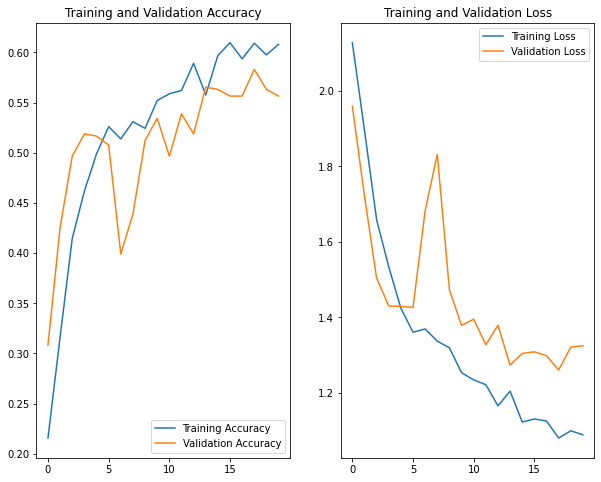

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Insights:
We can observe from the plots that training accuracy and validation accuracy does not differ by big margin and the model has achieved around 57% accuracy on the validation set with 61% accuracy in training set. 
We can conclude that there is some improvement compared to previous model and the augmentation helped to control the problem of overfitting.  

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [29]:
cols = ['ClassName', 'Count_%age']
lst = []
for i in range(9):
    a = class_names[i] + '/*'
    cnt = len(list(data_dir_train.glob(a)))/image_count_train
    lst.append([class_names[i], cnt*100])
df1 = pd.DataFrame(lst, columns=cols)
df1.sort_values(by='Count_%age', axis=0, ascending=False, inplace=True)
df1

,ClassName,Count_%age
5,pigmented benign keratosis,20.487805
3,melanoma,19.423503
1,basal cell carcinoma,16.674058
4,nevus,15.831486
7,squamous cell carcinoma,8.736142
8,vascular lesion,6.164080
0,actinic keratosis,5.055432
2,dermatofibroma,4.212860
6,seborrheic keratosis,3.414634


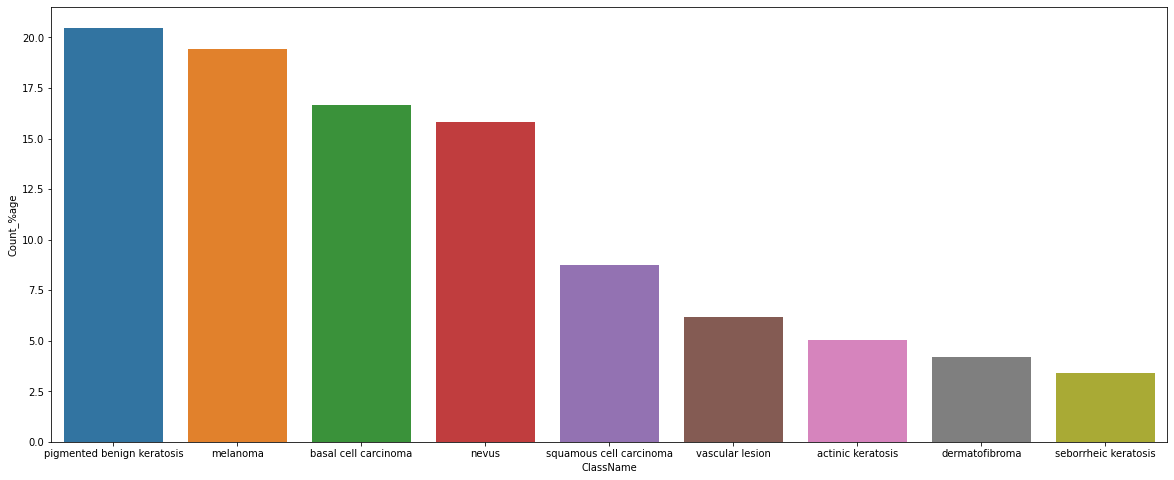

In [30]:
## Your code goes here.
import seaborn as sns
plt.figure(figsize=(20, 8))
sns.barplot(x = 'ClassName', y = 'Count_%age', data = df1)
plt.show()

#### **Todo:** Write your findings here: 
**Ans-** The dataset comprises of 9 class with total of 2255 images in train set. Based on bar plot we can infer that 4 classes namely pigmented benign keratosis, melanoma, basal cell carcinoma and nevus are high number of data compared to other 5 classes. Highest data allocation percentage is ~20% where as lowest is ~3.4%.  
#### - Which class has the least number of samples?
**Ans-** seborrheic keratosis has only ~3.4% of samples i.e 77 samples in the train set
#### - Which classes dominate the data in terms proportionate number of samples?
**Ans-** pigmented benign keratosis has 20.4% percentage of sample i.e. 462 samples in the train set


In [31]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/ISIC_0000025.jpg',
 '/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/ISIC_0000019.jpg',
 '/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/ISIC_0000028.jpg',
 '/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/ISIC_0000024.jpg',
 '/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/ISIC_0000023.jpg',
 '/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/ISIC_0000034.jpg',
 '/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/ISIC_0000032.jpg',
 '/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/ISIC_0000037.jpg',
 '/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I

In [54]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [55]:
dataframe_dict = dict(zip(path_list, lesion_list))

In [56]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,nevus
1,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,nevus
2,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,nevus
3,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,nevus
4,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,nevus
...,...,...
2250,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,squamous cell carcinoma
2251,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,squamous cell carcinoma
2252,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,squamous cell carcinoma
2253,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,squamous cell carcinoma


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [40]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [41]:
path_to_training_dataset = '/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEE3BB44B10>:   0%|          | 1/500 [00:00<01:00,  8.30 Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEE3BDBEDD0>: 100%|██████████| 500/500 [00:21<00:00, 22.85 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEE3BDC6A90>:   0%|          | 2/500 [00:00<00:35, 14.16 Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEE38288A90>: 100%|██████████| 500/500 [00:22<00:00, 22.47 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEE3BB5B890>:   0%|          | 1/500 [00:00<01:20,  6.17 Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEE3BB44850>: 100%|██████████| 500/500 [00:22<00:00, 22.01 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FEE38318D50>: 100%|██████████| 500/500 [01:51<00:00,  4.49 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FEE44357CD0>: 100%|██████████| 500/500 [01:58<00:00,  4.24 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEE44196E90>: 100%|██████████| 500/500 [00:22<00:00, 22.08 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FEE4312FBD0>: 100%|██████████| 500/500 [00:49<00:00, 10.06 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 197 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEE382C8450>: 100%|██████████| 500/500 [00:22<00:00, 22.33 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEE44181F50>:   0%|          | 1/500 [00:00<01:16,  6.49 Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEE3C498050>: 100%|██████████| 500/500 [00:23<00:00, 21.49 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [57]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [43]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output/nevus_original_ISIC_0025992.jpg_eea8e1ff-932b-4e04-bbae-f6a1e1ac3bb1.jpg',
 '/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output/nevus_original_ISIC_0029460.jpg_3d9e1568-ec05-4696-bfef-ffc095ae6fcf.jpg',
 '/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output/nevus_original_ISIC_0000315.jpg_69ba6616-c195-4984-8412-8e72fe615900.jpg',
 '/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output/nevus_original_ISIC_0000068.jpg_af9981ee-8137-4ba3-bad0-f72b3ae37f0d.jpg',
 '/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output/nevus_original_ISIC_0024948.jpg_d9e885cf-6424-484e-b160-5115ac96af93.jpg',
 '/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Tr

In [44]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [45]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [58]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df

,Path,Label
0,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,nevus
1,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,nevus
2,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,nevus
3,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,nevus
4,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,nevus
...,...,...
4495,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,squamous cell carcinoma
4496,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,squamous cell carcinoma
4497,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,squamous cell carcinoma
4498,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,squamous cell carcinoma


In [59]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       697
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [60]:
df2['Label'].value_counts()

pigmented benign keratosis    500
nevus                         500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
dermatofibroma                500
basal cell carcinoma          500
seborrheic keratosis          500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [61]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [62]:
data_dir_train='/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6755 files belonging to 9 classes.
Using 5404 files for training.


#### **Todo:** Create a validation dataset

In [63]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6755 files belonging to 9 classes.
Using 1351 files for validation.


#### **Todo:** Create your model (make sure to include normalization)
* layers.experimental.preprocessing.Rescaling is used to normalize data between (0,1) in RGB range [0,255].
* We have also used Dropout, a form of regularization, to handle overfitting. Adding Dropout to a layer randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. 
* It takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [64]:
## your code goes here
num_classes = 9

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)  


* I selected Adam optimizer because it achieves good results fast. This algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision. It combines the advantages of two other extensions of stochastic gradient descent : AdaGrad and RMSProp.  
* CrossEntropyLoss is the appropriate loss function for a classification model that outputs raw scores for each class.  
* Accuracy is chosen as the metric to determine the model performance.  

In [65]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)       

#### **Todo:**  Train your model

In [67]:
epochs = 50
## Your code goes here, use 50 epochs.
# your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 56s 317ms/step - loss: 2.2378 - accuracy: 0.2197 - val_loss: 1.4657 - val_accuracy: 0.4404
Epoch 2/50
169/169 [==============================] - 54s 308ms/step - loss: 1.4463 - accuracy: 0.4549 - val_loss: 1.5076 - val_accuracy: 0.4278
Epoch 3/50
169/169 [==============================] - 53s 305ms/step - loss: 1.3607 - accuracy: 0.4780 - val_loss: 1.3076 - val_accuracy: 0.5026
Epoch 4/50
169/169 [==============================] - 54s 309ms/step - loss: 1.2791 - accuracy: 0.5027 - val_loss: 1.2908 - val_accuracy: 0.4989
Epoch 5/50
169/169 [==============================] - 54s 311ms/step - loss: 1.2342 - accuracy: 0.5202 - val_loss: 1.2277 - val_accuracy: 0.5344
Epoch 6/50
169/169 [==============================] - 55s 314ms/step - loss: 1.1635 - accuracy: 0.5496 - val_loss: 1.1957 - val_accuracy: 0.5440
Epoch 7/50
169/169 [==============================] - 55s 313ms/step - loss: 1.1082 - accuracy: 0.5762 - val_loss: 1.1764 - val_ac

#### After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned.  

#### **Todo:**  Visualize the model results

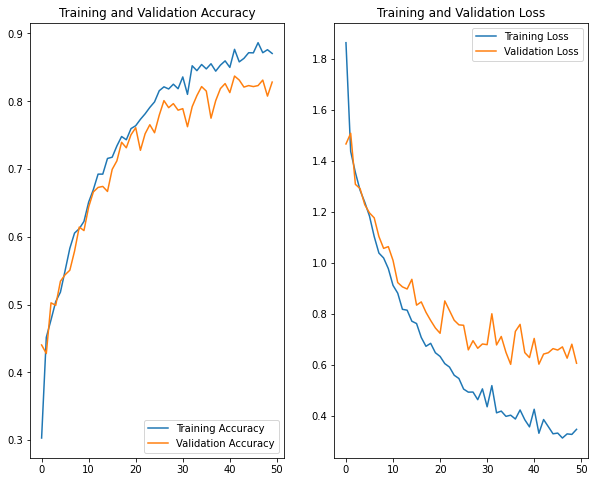

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
  
#### **Ans:**    
Augmentor allows us to create an augmentation pipeline, which chains together operations that are applied stochastically, where the parameters of each of these operations are also chosen at random, within a range specified by the user. This means that each time an image is passed through the pipeline, a different image is returned. Depending on the number of operations in the pipeline, and the range of values that each operation has available, a very large amount of new image data can be created in this way.  

The balancing of each class using Augmentor has helped to improve the performance of the model drastically. We can see from the plot that both training and validation accuracy increases steadily. Final accuracy achieved for training set is ~88% and validation set is ~83%. We can also infer that Augmentation also helped to control the initial overfitting issue.


In [69]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', 
    batch_size=32, image_size=(img_height,img_width), shuffle=False, seed=123, 
    interpolation='bilinear', follow_links=False
)

Found 118 files belonging to 9 classes.


#### Evaluating the model in one of the test image

In [89]:
img_path = '/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test/pigmented benign keratosis/ISIC_0024336.jpg'
img = keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print('Predictions:- ',predictions)

score = tf.nn.relu(predictions[0])
print("This image most likely belongs to {} with a {:.2f} prediction score."
    .format(class_names[np.argmax(score)], np.max(score))
)

Predictions:-  [[ -0.43978396   5.4074364    4.0997195   -1.8060739    3.1104054
   10.983013    -2.2330725   -5.8064165  -13.560007  ]]
This image most likely belongs to pigmented benign keratosis with a 10.98 prediction score.
